In [59]:
from transformers import GPT2LMHeadModel
import tiktoken

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
import torch
import torch.nn as nn
batch_size = 32
seq_length = 1024
embedding_dim = 768
n_embed = 768
n_head = 12
vocab_size = 50257
c_attn = nn.Linear(n_embed, n_embed * 3)
x = torch.rand(batch_size, seq_length, embedding_dim)


In [20]:
B, T, C = x.size()
qkv = c_attn(x)
print(qkv.size())
q, k, v = qkv.split(n_embed, dim=2)
print("q.size():", q.size())

torch.Size([32, 1024, 2304])
q.size(): torch.Size([32, 1024, 768])


In [21]:
q = q.view(B, T, n_head, C // n_head) # (batch, seq_len, n_head, head_dim)
print("q.view:", q.size())
q = q.transpose(1, 2)
print("q.transpose:", q.size()) # (batch, n_head, seq_len, head_dim)

q.view: torch.Size([32, 1024, 12, 64])
q.transpose: torch.Size([32, 12, 1024, 64])


In [19]:
print(k.size())
print(k.size(-1))

torch.Size([32, 1024, 768])
768


In [25]:
size = (2,2)
torch.ones(*size) @ torch.ones(*size)

tensor([[2., 2.],
        [2., 2.]])

In [22]:
wte = nn.Embedding(vocab_size, embedding_dim)
wpe = nn.Embedding(seq_length, embedding_dim)
x = torch.randint(0, 50257,(8, 256), dtype=torch.long)
B, T = x.size()
pos = torch.arange(0, x.size(1), dtype=torch.long, device=x.device)


x1 = wte(x)
x2 = wpe(pos)

In [51]:
import matplotlib.pyplot as plt

def show_matrix(m, label=""):
    if label:
        print(f"matrix for {label}")
    print(f"size: {m.size()}")
    print(f"mean: {m.mean()}")
    print(f"std: {m.std()}")

    col_means = m.mean(dim=0)
    col_stds = m.std(dim=0)

    print("--- Column Statistics (768 values) ---")
    print(f"Shape of Column Means: {col_means.shape}")
    print(f"Mean of all Column Means: {col_means.mean():.4f}") # Should be near zero for healthy models
    print(f"Std of all Column Means: {col_stds.mean():.4f}") # Should be near zero for healthy models

    # --- B. Row (Vector) Statistics ---
    # Collapses the embedding dimension (dim=1) to get one value per word (50257 values)
    row_means = m.mean(dim=1)
    row_stds = m.std(dim=1)

    print("--- Row Statistics (50257 values) ---")
    print(f"Shape of Row STDs: {row_stds.shape}")
    print(f"Mean of all Row STDs: {row_means.mean():.4f}") # Should be near one for healthy models
    print(f"Std of all Row STDs: {row_stds.mean():.4f}") # Should be near one for healthy models
    print("-" * 20)


def show_histogram(m):
    # --- 1. Calculate the Metrics ---

    # A. Column Means (768 values)
    # Measures the average value for each of the 768 feature dimensions across the entire vocabulary.
    col_means = m.mean(dim=1).cpu().numpy()

    # B. Vector Norms (50257 values)
    # Measures the magnitude (Euclidean length) of each word vector.
    # The L2 norm is calculated across the embedding dimension (dim=1).
    vector_norms = torch.linalg.norm(m, dim=1).cpu().numpy()

    # --- 2. Generate Histograms ---
    plt.figure(figsize=(15, 6))

    # --- Plot 1: Histogram of Column Means ---
    plt.subplot(1, 2, 1)
    plt.hist(col_means, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Column Means ({col_means.shape} Dimensions)')
    plt.xlabel('Mean Value per Dimension')
    plt.ylabel('Frequency')
    # For healthy initialization (like torch.randn), this should be centered near 0.
    plt.axvline(x=0, color='r', linestyle='--', label='Zero Mean')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)

    # --- Plot 2: Histogram of Vector Norms ---
    plt.subplot(1, 2, 2)
    plt.hist(vector_norms, bins=50, color='lightcoral', edgecolor='black')
    plt.title(f'Distribution of Vector Norms ({vocab_size} Words)')
    plt.xlabel('L2 Norm (Magnitude)')
    plt.ylabel('Frequency')
    # A Gaussian initialization often leads to norms centered around sqrt(dim) ~ sqrt(768) ~ 27.7
    plt.grid(axis='y', alpha=0.5)

In [45]:
show_matrix(x1)
show_matrix(x2)

show_matrix(x1 + x2)

size: torch.Size([8, 256, 768])
mean: 0.00012317435175646096
std: 0.9999115467071533
--- Column Statistics (768 values) ---
Shape of Column Means: torch.Size([256, 768])
Mean of all Column Means: 0.0001
Std of all Column Means: 0.9649
--- Row Statistics (50257 values) ---
Shape of Row STDs: torch.Size([8, 768])
Mean of all Row STDs: 0.0001
Std of all Row STDs: 0.9989
--------------------
size: torch.Size([256, 768])
mean: -0.0012113641714677215
std: 1.0024888515472412
--- Column Statistics (768 values) ---
Shape of Column Means: torch.Size([768])
Mean of all Column Means: -0.0012
Std of all Column Means: 1.0015
--- Row Statistics (50257 values) ---
Shape of Row STDs: torch.Size([256])
Mean of all Row STDs: -0.0012
Std of all Row STDs: 1.0022
--------------------
size: torch.Size([8, 256, 768])
mean: -0.0010881893103942275
std: 1.4159458875656128
--- Column Statistics (768 values) ---
Shape of Column Means: torch.Size([256, 768])
Mean of all Column Means: -0.0011
Std of all Column Means

In [7]:
wte.weight.mean()

tensor(-1.4012e-05, grad_fn=<MeanBackward0>)

In [8]:
wte.weight.std()

tensor(1.0000, grad_fn=<StdBackward0>)

size: torch.Size([50257, 768])
mean: 0.00037981776404194534
std: 0.14369554817676544
--- Column Statistics (768 values) ---
Shape of Column Means: torch.Size([768])
Mean of all Column Means: 0.0004
Std of all Column Means: 0.1216
--- Row Statistics (50257 values) ---
Shape of Row STDs: torch.Size([50257])
Mean of all Row STDs: 0.0004
Std of all Row STDs: 0.1429
--------------------


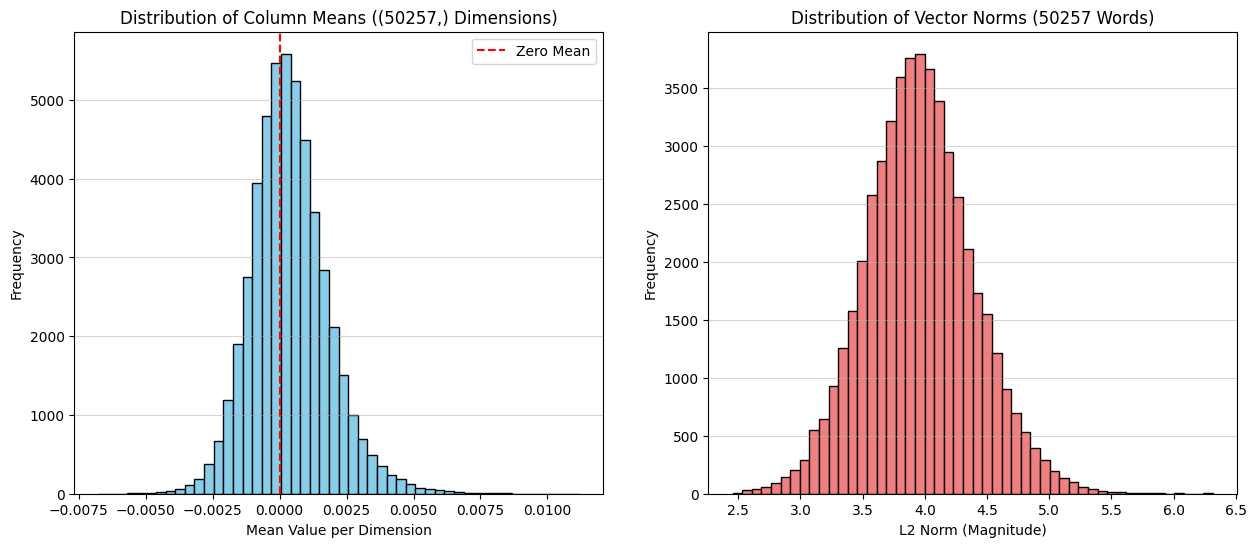

In [52]:
gpt2_wte = sd_hf['transformer.wte.weight']
gpt2_wte.shape
show_matrix(gpt2_wte)
show_histogram(gpt2_wte)


In [91]:
def show_token_examples(emb, tokenizer):
    def print_tokens(tokens):
        print(tokenizer.decode_tokens_bytes(tokens.tolist()))

    K = 10
    row_means = emb.mean(dim=1)
    high_means, high_mean_token_ids = torch.topk(row_means, k=K, largest=True)
    low_means, low_mean_token_ids = torch.topk(row_means, k=K, largest=False)
    print("mean")
    print(high_means)
    print_tokens(high_mean_token_ids)
    print(low_means)
    print_tokens(low_mean_token_ids)

    row_std = emb.std(dim=1)
    high_std, high_std_token_ids = torch.topk(row_std, k=K, largest=True)
    low_std, low_std_token_ids = torch.topk(row_std, k=K, largest=False)
    print("std")
    print(high_std)
    print_tokens(high_std_token_ids)
    print(low_std)
    print_tokens(low_std_token_ids)

In [89]:
tokenizer = tiktoken.get_encoding("gpt2")

In [92]:
show_token_examples(gpt2_wte, tokenizer)

mean
tensor([0.0112, 0.0096, 0.0093, 0.0092, 0.0089, 0.0087, 0.0086, 0.0086, 0.0084,
        0.0083])
[b'elsius', b'advertisement', b'o\xc4\x9f', b' Skydragon', b'issance', b'selves', b'halla', b'omething', b'Redditor', b'ascript']
tensor([-0.0068, -0.0064, -0.0063, -0.0057, -0.0054, -0.0053, -0.0053, -0.0051,
        -0.0050, -0.0049])
[b' UCHIJ', b'://', b' trave', b'ItemTracker', b'atron', b'isphere', b'luaj', b'thumbnails', b'noxious', b'taboola']
std
tensor([0.2280, 0.2264, 0.2244, 0.2203, 0.2173, 0.2171, 0.2170, 0.2166, 0.2121,
        0.2118])
[b'SPONSORED', b'\x96\x9a', b'soDeliveryDate', b'enegger', b'Reviewer', b'theless', b'yip', b'inventoryQuantity', b'interstitial', b'76561']
tensor([0.0886, 0.0890, 0.0893, 0.0893, 0.0898, 0.0899, 0.0905, 0.0910, 0.0911,
        0.0914])
[b' at', b' in', b' on', b' an', b' for', b' as', b' that', b' 10', b' to', b' 15']


In [ ]:
# qwen 3 testing


In [1]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model="gpt2")
set_seed(42)
generator("Hello, I'm a language model", max_length=30, num_return_sequences=5)

/Users/kh/workspace/build_gpt2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kh/workspace/build_gpt2/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for op

[{'generated_text': "Hello, I'm a language modeler. I use the standard C++ compiler for my code, and C++ code is probably the best way to learn C++. So, I'm not going to let you have a bad day, you're welcome, I just want to make a note of my code and know what you're thinking about.\n\nThere's a lot of stuff in my code that I'm not using and I'm not going to get it right. But I'll try to do it with good practice, and use my code to write nice things.\n\nWhy are you using C++?\n\nWhy did you choose C++? Well, I was just getting started with C++, and it was a nice language, so I think in the end that's what I like about C++. And actually, I think that a lot of people use C++, and I think that they're going to find a lot of things to love about it.\n\nSo I think that's why I chose C++, is because I think that a lot of people like these languages, so I think people really like these languages, and I think that's what I like about them.\n\nSo I think that's why I chose C++, because I think

In [11]:
# multinomial sampling

import torch

# 1-D input (single distribution)
probabilities = torch.tensor([0.1, 0.2, 0.7])
samples = torch.multinomial(probabilities, num_samples=5, replacement=True)
print(f"Samples from a single distribution: {samples}")

# 2-D input (batch of distributions)
batch_probabilities = torch.tensor([[0.2, 0.8], [0.5, 0.5]])
batch_samples = torch.multinomial(batch_probabilities, num_samples=3, replacement=True)
print(f"Samples from a batch of distributions:\n{batch_samples}")

Samples from a single distribution: tensor([2, 2, 2, 2, 2])
Samples from a batch of distributions:
tensor([[1, 1, 1],
        [0, 1, 1]])


In [16]:
import torch
import torch.nn.functional as F

a = torch.rand(5,6)
print(a)
print(a.sum(dim=1))
b = F.softmax(a, dim=1)
print(b)
print(b.sum(dim=1))



tensor([[0.4565, 0.3817, 0.2465, 0.0543, 0.0958, 0.2323],
        [0.9829, 0.2585, 0.1642, 0.6212, 0.6378, 0.7740],
        [0.8801, 0.7784, 0.0042, 0.5443, 0.8029, 0.4538],
        [0.2054, 0.9767, 0.3130, 0.2153, 0.0492, 0.5223],
        [0.7216, 0.6107, 0.5989, 0.1208, 0.0331, 0.5088]])
tensor([1.4670, 3.4386, 3.4638, 2.2819, 2.5938])
tensor([[0.2039, 0.1892, 0.1653, 0.1364, 0.1422, 0.1630],
        [0.2414, 0.1170, 0.1065, 0.1682, 0.1710, 0.1959],
        [0.2168, 0.1958, 0.0903, 0.1549, 0.2007, 0.1415],
        [0.1331, 0.2878, 0.1482, 0.1344, 0.1138, 0.1827],
        [0.2156, 0.1930, 0.1907, 0.1182, 0.1083, 0.1743]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [2]:
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data, allowed_special={"<|space|>"})
print(tokens[:24])


[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [37]:
import torch
buf = torch.tensor(tokens[:24+1])
a = buf[:24].view(4,6)
b=buf[1:].view(4,6)
print(b)
print(b[:, -1].unsqueeze(1))


tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])
tensor([[5120],
        [2740],
        [ 198],
        [ 198]])


In [32]:
import numpy as np

token_id = torch.tensor([23, 22307, 25])
vocab_size = 50257

b = torch.zeros(len(token_id), vocab_size)
b.scatter_(1, token_id.unsqueeze(1), 1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [36]:
token_id.unsqueeze(1)

tensor([[   23],
        [22307],
        [   25]])

In [33]:
b.shape

torch.Size([3, 50257])

In [21]:
a[:,-1,:]

tensor([[5, 7, 8, 6],
        [5, 8, 5, 5]])

In [ ]:
import torch
import tiktoken

device = 'mps'


class DataLoaderLite:
    def __init__(self, batch_size, block_size):
        with open('input.txt', 'r') as f:
            self.text = f.read()
        self.enc = tiktoken.get_encoding("gpt2")
        self.tokens = torch.tensor(self.enc.encode(self.text))
        self.batch_size = batch_size
        self.block_size = block_size
        self.tokens_per_batch = self.batch_size * self.block_size
        self.current_idx = 0
        
    def next_batch(self):
        base = self.tokens[self.current_idx : self.current_idx + self.tokens_per_batch + 1]
        x = base[:-1].view(self.batch_size, self.block_size)
        y = base[1:].view(self.batch_size, self.block_size)
        self.current_idx += self.tokens_per_batch
        if (self.current_idx + 1 >= len(self.tokens)):
            self.current_idx = 0
        return x, y
        

In [28]:
dl = DataLoaderLite(batch_size=4, block_size=32)
dl.next_batch()

(tensor([[ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
           3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
            461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198,
           1639,   389],
         [  477, 12939,  2138,   284,  4656,   621,   284,  1145,   680,    30,
            198,   198,  3237,    25,   198,  4965,  5634,    13, 12939,    13,
            198,   198,  5962, 22307,    25,   198,  5962,    11,   345,   760,
            327,  1872],
         [  385,  1526, 28599,   318,  4039,  4472,   284,   262,   661,    13,
            198,   198,  3237,    25,   198,  1135,   760,   470,    11,   356,
            760,   470,    13,   198,   198,  5962, 22307,    25,   198,  5756,
            514,  1494],
         [  683,    11,   290,   356,  1183,   423, 11676,   379,   674,   898,
           2756,    13,   198,  3792,   470,   257, 15593,    30,   198,   198,
           3237,    25,   198,  2949,   517, 

In [12]:
import torch
import tiktoken

device = 'mps'
with open('input.txt', 'r') as f:
    text = f.read()
text = text[:1000]
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(text)
B, T = 4, 32

def get_batch(tokens):
    tokens = torch.tensor(tokens)
    idx = torch.randint(0, len(tokens) - T, (B,))
    x = torch.stack([tokens[i:i + T] for i in idx])
    y = torch.stack([tokens[i + 1:i + T + 1] for i in idx])
    return x, y

get_batch(tokens)

(tensor([[   11,   318,   355,   281,   198, 24807,   284,  1948,   786,   511,
          20038,    26,   674,   198,    82, 13712,   590,   318,   257,  4461,
            284,   606,  3914,   514, 15827,   428,   351,   198,   454,   279,
           7938,    11],
         [ 1929,  4316,   462,    11,   356,  1244,  4724,   484, 22598,   514,
          31533,   306,    26,   198,  4360,   484,   892,   356,   389,  1165,
          13674,    25,   262, 10904,  1108,   326,   198,  2001, 42267,   514,
             11,   262],
         [ 1497,    11,  1497,     0,   198,   198, 12211, 22307,    25,   198,
           3198,  1573,    11,   922,  4290,    13,   198,   198,  5962, 22307,
             25,   198,  1135,   389, 17830,  3595,  4290,    11,   262,  1458,
           1173,  1547],
         [  198,    82, 13712,   590,   318,   257,  4461,   284,   606,  3914,
            514, 15827,   428,   351,   198,   454,   279,  7938,    11,   304,
            260,   356,  1716,   374,  1124, 